In [91]:
# Import libraries

import rasterio as rio
from affine import Affine
from rasterio.crs import CRS
import numpy as np

import math
import os
import json

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from mpl_toolkits import axes_grid1
%matplotlib inline

import cartoframes 
from vega3 import Vega 

pd.options.display.max_columns = 105
pd.options.display.max_rows = 200

In [68]:
Config="""
{
  "range": {
    "dotSize": [20, 250],
    "category": [
      "#3BB2D0",
      "#2C75B0",
      "#FAB72E",
      "#EF4848",
      "#65B60D",
      "#717171"
    ],
    "category20": [
      "#3BB2D0",
      "#2C75B0",
      "#FAB72E",
      "#EF4848",
      "#65B60D",
      "#C32D7B",
      "#F577B9",
      "#5FD2B8",
      "#F1800F",
      "#9F1C00",
      "#A5E9E3",
      "#B9D765",
      "#393F44",
      "#CACCD0",
      "#717171"
    ],
    "ordinal": { "scheme": "greens" },
    "ramp": { "scheme": "purples" }
  },
  "axis": {
    "labelFontSize": 13,
    "labelFont": "Lato",
    "labelColor": "#717171",
    "labelPadding": 10,
    "ticks": true,
    "tickSize": 5,
    "tickColor": "#A9ABAD",
    "tickOpacity": 0.5,
    "tickExtra": false
  },
  "axisX": {
    "bandPosition": 0.5,
    "domainWidth": 1.2,
    "domainColor": "#A9ABAD",
    "labelAlign": "center",
    "labelBaseline": "top"
  },
  "axisY": {
    "domain": false,
    "labelAlign": "left",
    "labelBaseline": "bottom",
    "tickOpacity": 0.5,
    "grid": true,
    "ticks": false,
    "gridColor": "#A9ABAD",
    "gridOpacity": 0.5
  },
  "mark": {
    "fill": "#3BB2D0"
  },
  "symbol": {
    "fill": "#3BB2D0",
    "stroke": "#fff"
  },
  "rect": {
    "cornerRadius": 0.3,
    "fill": "#3BB2D0"
  },
  "line": {
    "interpolate": "linear",
    "stroke": "#3BB2D0",
    "fillOpacity": 0
  }
}
"""

In [63]:
# Functions
def create_transform(row_width,row_rotation, upper_right_x,
                    column_rotation, column_height, upper_right_y):
    
    return(Affine(row_width,row_rotation,upper_right_x,
                  column_rotation, column_height, upper_right_y))

# http://mathforum.org/library/drmath/view/63767.html
def calc_cell_area(lat):
    R = EARTH_RADIUS

    lat = lat*(np.pi/180)
    lat_res = CELL_SIZE*(np.pi/180)
    lon_res = lat_res

    #print('Processing lat {}'.format(lat))
    theta1 = lat
    theta2 = lat-lat_res
    
    h1 = R*(1-np.sin(theta1))
    h2 = R*(1-np.sin(theta2))
    
    #A = 2*np.pi*R*np.abs(h1-h2)*(lon_res)/360
    A = R*np.abs(h1-h2)*(lon_res)
    #print('Area {}'.format(A))

    return(A)

def create_global_areal_raster(filename):  
    lons = np.arange(90, -90, -CELL_SIZE)
    assert(len(lons)==NUM_ROWS)
    # https://stackoverflow.com/questions/1550130/cloning-row-or-column-vectors
    areas = np.array([list(map(calc_cell_area, lons)),]*NUM_COLS).T
    
    dtype = np.float32
    profile = {
        'driver': 'GTiff', 
        'dtype': dtype, 
        'nodata': 0, 
        'width': NUM_COLS, 
        'height': NUM_ROWS, 
        'count': 1, 
        'crs': CRS(_CRS), 
        'transform':TRANSFORM,
        'blockxsize': 128, 
        'blockysize': 128, 
        'tiled': True, 
        'compress': 'lzw', 
        'interleave': 'band'
    }
    
    print('Shape of areas: {}'.format(areas.shape))
    
    with rio.open(filename, "w", **profile) as dst:
        dst.write(areas.astype(dtype), indexes=1)
        
def create_empty_raster(filename):
    placeholders = np.zeros((NUM_ROWS, NUM_COLS))
    
    dtype = np.uint8
    profile = {
        'driver': 'GTiff', 
        'dtype': dtype, 
        'nodata': 0, 
        'width': NUM_COLS, 
        'height': NUM_ROWS, 
        'count': 1, 
        'crs': CRS(_CRS), 
        'transform':TRANSFORM,
        'blockxsize': 128, 
        'blockysize': 128, 
        'tiled': True, 
        'compress': 'lzw', 
        'interleave': 'band'
    }
        
    with rio.open(filename, "w", **profile) as dst:
        dst.write(placeholders.astype(dtype), indexes=1)
        
def calc_area(area_raster, ix):
    return(area_raster[ix[0], ix[1]])

In [33]:
# Constants
LAT_COL = 'LATITUDE'
LON_COL = 'LONGITUDE'
YEAR_COL = 'YEAR'
VALUE_COL = 'SEVERITY_CODE'
CELL_SIZE = .04 #degrees
NUM_COLS = int(360 / CELL_SIZE)
NUM_ROWS = int(180 / CELL_SIZE)
TRANSFORM = create_transform(CELL_SIZE,0,-180,0,-CELL_SIZE,90)
BLEACHING_ALERTS_RASTER = '/Users/nathansuberi/Desktop/RW_Data/bleaching_alerts.tif'
AREA_RASTER = '/Users/nathansuberi/Desktop/RW_Data/area_raster.tif'
EARTH_RADIUS = 6371. # kilometers
_CRS = {'init': 'epsg:4326'}
BLEACHING_RASTER_FILENAME = '/Users/nathansuberi/Desktop/RW_Data/bleaching_alerts_year{YEAR}.tif'

In [10]:
# Create raster of areas
create_global_areal_raster(AREA_RASTER)
with rio.open(AREA_RASTER, "r") as src:
    bleaching_area_raster = src.read(indexes=1)
    
areas = list(map(lambda row: row[0], bleaching_area_raster))

# Sanity check - does area of the raster add up to approximate surface area of the Earth?
# According to Google, Surface Area of Earth ~ 510.1 million km²
print(sum(areas)*NUM_COLS)

Shape of areas: (4500, 9000)
510064472.111


In [48]:
# Load bleaching alerts
BLEACHING_DATA = '/Users/nathansuberi/Desktop/RW_Data/Bleaching_alerts.xlsx'
b_alerts_orig = pd.read_excel(BLEACHING_DATA)

# Convert to GeoDataFrame
geometry = [shp.geometry.Point(xy) for xy in zip(b_alerts_orig[LON_COL], b_alerts_orig[LAT_COL])]
b_alerts = b_alerts_orig.drop([LON_COL, LAT_COL], axis=1)

b_alerts = gpd.GeoDataFrame(b_alerts, crs=_CRS, geometry=geometry)
b_alerts.head()

,COUNTRY,LOCATION,SITE_NAME,MONTH,YEAR,DEPTH,SEVERITY_CODE,PERCENT_BLEACHED,MORTALITY_CODE,PERCENT_MORTALITY,SURVEY_TYPE,SOURCE,NAME,CITATION,COMMENTS,ENTRY_CODE,DATABASE_CODE,geometry
0,Jamaica,Jamaica,NaN,NaN,1963,NaN,-1,NaN,NaN,NaN,NaN,ReefBase,NaN,NaN,"Some of the surviving corals bleached (Goreau,...",NaN,1,POINT (-77.25 18.2)
1,Puerto Rico,Puerto Rico,NaN,NaN,1969,NaN,-1,NaN,NaN,NaN,NaN,ReefBase,NaN,NaN,An intensive and extensive bleaching event occ...,NaN,1,POINT (-66.43333333 17.86666667)
2,Colombia,Providencia Island ( Isla de Providencia ),NaN,NaN,1969,1-20 m,-1,NaN,NaN,NaN,NaN,ReefBase,NaN,NaN,,NaN,1,POINT (-81.38333333 13.35833333)
3,Florida (USA),Middle Sambo Reef,NaN,NaN,1973,NaN,2,NaN,NaN,NaN,NaN,ReefBase,NaN,NaN,Millepora complanata showed the greatest incid...,NaN,1,POINT (-81.675 24.49)
4,Panama,Chiriqui Gulf ( Golfo de Chiriqui ),NaN,NaN,1976,NaN,-1,NaN,NaN,NaN,NaN,ReefBase,NaN,NaN,At irregularly low tides with two hour exposur...,NaN,1,POINT (-82.33333333 8)


In [12]:
# World country boundaries for context
country_bounds = gpd.read_file("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]

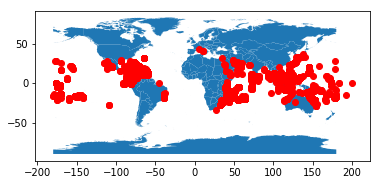

In [13]:
# Visualize
base = country_bounds.plot()
b_alerts.plot(ax=base, marker="o", color="red")

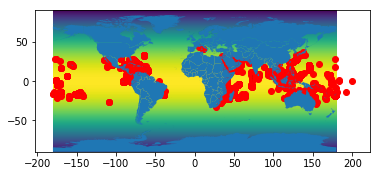

In [14]:
# Raster data
# Extent parameter is necessary here for alignment
plt.imshow(bleaching_area_raster, extent = [-180, 180, -90, 90])

# Get current axes
ax = plt.gca()

# Use these axes to plot the vector data
b_alerts.plot(ax=ax, marker="o", color="red")
country_bounds.plot(ax=ax)

In [22]:
# Create placeholder raster
# Create raster of areas
create_empty_raster(BLEACHING_ALERTS_RASTER)
with rio.open(BLEACHING_ALERTS_RASTER, "r") as src:
    bleaching_alerts_raster = src.read(indexes=1)
    
print(bleaching_alerts_raster.shape)

(4500, 9000)


In [40]:
bleaching_alerts_raster[:2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [65]:
# Overlay GeoDataFrame with the raster
b_alerts_by_year = b_alerts_orig.groupby(YEAR_COL)
years = list(b_alerts_by_year.groups.keys())

bleached_areas = {}

for year in years:
    print("Year:", year)
    # Initialize blank bleaching alerts raster
    bleaching_alerts_copy = bleaching_alerts_raster.copy()
    
    # Grab bleaching alerts for target year
    bleaching_data = b_alerts_by_year.get_group(year)
    #print("Shape of records for year {}: {}".format(year, bleaching_data.shape))
    #print("bleaching data: {}".format(bleaching_data.head()))
   
    # Loop over bleaching data - increment corresponding bleaching_alerts_raster cell
    for ix, obs in bleaching_data.iterrows():
        row = math.floor(obs[LAT_COL]/CELL_SIZE)
        col = math.floor(obs[LON_COL]/CELL_SIZE)
        bleaching_alerts_copy[row,col]+=1

    # Write out results
    dtype = np.float32
    profile = {
        'driver': 'GTiff', 
        'dtype': dtype, 
        'nodata': -1, 
        'width': NUM_COLS, 
        'height': NUM_ROWS, 
        'count': 1, 
        'crs': CRS(_CRS), 
        'transform':TRANSFORM,
        'blockxsize': 128, 
        'blockysize': 128, 
        'tiled': True, 
        'compress': 'lzw', 
        'interleave': 'band'
    }
    filename = BLEACHING_RASTER_FILENAME.format(YEAR=year)
    with rio.open(filename, "w", **profile) as dst:
        dst.write(bleaching_alerts_copy.astype(dtype), indexes=1)
        
    # Multiply by area raster
    bleached_ix = np.where(bleaching_alerts_copy>0)
    bleached_ix = list(zip(bleached_ix[0], bleached_ix[1]))
    #print('Bleached indices: {}'.format(bleached_ix))
    num_bleached_cells = len(bleached_ix)
    print('Num bleached cells: {}'.format(num_bleached_cells))
    bleached_area = sum(map(lambda ix: calc_area(bleaching_area_raster, ix), bleached_ix))
    print('Bleached area: {}'.format(bleached_area))
    
    bleached_areas[year] = {
        'num_cells':num_bleached_cells,
        'bleached_area':bleached_area
    }

Year: 1963
Num bleached cells: 1
Bleached area: 6.185449600219727
Year: 1969
Num bleached cells: 2
Bleached area: 10.63175106048584
Year: 1973
Num bleached cells: 1
Bleached area: 8.203834533691406
Year: 1976
Num bleached cells: 1
Bleached area: 2.7600855827331543
Year: 1977
Num bleached cells: 1
Bleached area: 0.22787758708000183
Year: 1979
Num bleached cells: 6
Bleached area: 28.421589136123657
Year: 1980
Num bleached cells: 11
Bleached area: 75.57803726196289
Year: 1981
Num bleached cells: 2
Bleached area: 9.386854648590088
Year: 1982
Num bleached cells: 20
Bleached area: 107.66563427448273
Year: 1983
Num bleached cells: 48
Bleached area: 163.44219794869423
Year: 1984
Num bleached cells: 2
Bleached area: 11.133323907852173
Year: 1985
Num bleached cells: 3
Bleached area: 18.27434754371643
Year: 1986
Num bleached cells: 13
Bleached area: 86.29160451889038
Year: 1987
Num bleached cells: 99
Bleached area: 584.5681511759758
Year: 1988
Num bleached cells: 9
Bleached area: 71.9929823875427

In [79]:
CARTO_USER = #os.environ.get('CARTO_WRI_RW_USER')
CARTO_KEY = #os.environ.get('CARTO_WRI_RW_KEY')

cc = cartoframes.CartoContext(base_url='https://{}.carto.com/'.format(CARTO_USER),
                              api_key=CARTO_KEY)

In [89]:
data = pd.DataFrame.from_dict(bleached_areas, orient='index').reset_index()
data.columns = ['year', 'num_cells', 'bleached_area']
cc.write(data, 'sotp_bleaching_alerts')

Table successfully written to CARTO: https://wri-rw.carto.com/dataset/sotp_bleaching_alerts


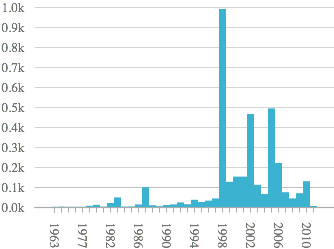

In [97]:
# Create Vega3 visualization
specV3=json.loads("""
{
  "autosize": {
    "type": "pad",
    "resize": true,
    "contains": "padding"
  },
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT year as x, num_cells as y FROM sotp_bleaching_alerts ORDER  BY year",
      "format": {
        "type": "json",
        "property": "rows"
      },
      "transform": [
        {
          "type": "window",
          "sort": {
            "field": "x",
            "order": "ascending"
          }
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "domain": {
        "data": "table",
        "field": "x"
      },
      "range": "width",
      "padding": 0.05,
      "round": true
    },
    {"type": "linear",
      "name": "y",
      "domain": {
        "data": "table",
        "field": "y"
      },
      "nice": true,
      "range": "height"
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelOverlap":"parity",
      "encode": {
        "labels": {
          "update": {
            "angle": {
              "value": 90
            },
            "align": {
              "value": "left"
            },
            "baseline": {
              "value": "middle"
            }
          }
        }
      }
    },
    {
      "orient": "left",
      "labelOverlap":"parity",
      "scale": "y",
      "format": "2s"
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {
        "data": "table"
      },
      "encode": {
        "enter": {
          "x": {
            "scale": "x",
            "field": "x"
          },
          "width": {
            "scale": "x",
            "band": 1
          },
          "y": {
            "scale": "y",
            "field": "y"
          },
          "y2": {
            "scale": "y",
            "value": 0
          }
        },
        "update": {
          "opacity": {
            "value": 1
          }
        },
        "hover": {
          "opacity": {
            "value": 0.8
          }
        }
      }
    }
  ]
}
""")
vega4view=dict(specV3)
vega4view['config']=json.loads(Config)
vega4view['width']=300
vega4view['height']=200
Vega(vega4view)

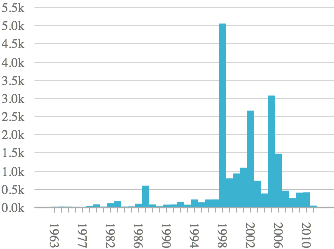

In [98]:
# Create Vega3 visualization
specV3=json.loads("""
{
  "autosize": {
    "type": "pad",
    "resize": true,
    "contains": "padding"
  },
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT year as x, bleached_area as y FROM sotp_bleaching_alerts ORDER  BY year",
      "format": {
        "type": "json",
        "property": "rows"
      },
      "transform": [
        {
          "type": "window",
          "sort": {
            "field": "x",
            "order": "ascending"
          }
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "domain": {
        "data": "table",
        "field": "x"
      },
      "range": "width",
      "padding": 0.05,
      "round": true
    },
    {"type": "linear",
      "name": "y",
      "domain": {
        "data": "table",
        "field": "y"
      },
      "nice": true,
      "range": "height"
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelOverlap":"parity",
      "encode": {
        "labels": {
          "update": {
            "angle": {
              "value": 90
            },
            "align": {
              "value": "left"
            },
            "baseline": {
              "value": "middle"
            }
          }
        }
      }
    },
    {
      "orient": "left",
      "labelOverlap":"parity",
      "scale": "y",
      "format": "2s"
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {
        "data": "table"
      },
      "encode": {
        "enter": {
          "x": {
            "scale": "x",
            "field": "x"
          },
          "width": {
            "scale": "x",
            "band": 1
          },
          "y": {
            "scale": "y",
            "field": "y"
          },
          "y2": {
            "scale": "y",
            "value": 0
          }
        },
        "update": {
          "opacity": {
            "value": 1
          }
        },
        "hover": {
          "opacity": {
            "value": 0.8
          }
        }
      }
    }
  ]
}
""")
vega4view=dict(specV3)
vega4view['config']=json.loads(Config)
vega4view['width']=300
vega4view['height']=200
Vega(vega4view)